# Pset 10: the adventure of the moonlighting genes


## 0.1 Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 0.1 Loading Data
We want to pre-load Adler's data so we can use it later in the pset.
We also want to use the list of gene names for our own synthetic data so it makes sense to load it early.
We will also be extracting all the values, without any gene names, into out V matrix that we can use later.

In [50]:
file = "w10-data.tbl"
df = pd.read_table(file, delim_whitespace=True, header=None)
genes = df[0].values
V_a = df.iloc[:,1:]
df

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,anise,1453,11100,4600,6130,8434,9249,2232,10746,4745,...,2859,715,10075,1816,196,3506,3454,3576,6269,835
1,apricot,944,14,1591,142,372,568,1374,154,582,...,375,1257,217,300,2250,460,578,415,1330,1387
2,artichoke,883,155,278,720,23,175,15,206,560,...,922,395,122,557,465,400,512,825,27,609
3,arugula,228,35,69,158,9,44,2,48,115,...,198,94,44,135,105,84,114,167,3,134
4,asparagus,608,5,1065,89,262,409,859,87,357,...,257,791,156,199,1429,261,354,255,849,887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,wasabi,391,54,102,287,11,67,6,78,247,...,335,133,58,268,200,141,216,322,10,236
96,watercress,5149,755,1499,3871,136,923,79,1081,3300,...,4759,2098,917,3411,2678,2147,2935,4367,153,3260
97,watermelon,75,559,279,295,429,482,121,532,250,...,147,43,491,100,12,188,160,191,364,41
98,yam,301,2598,1041,1369,1901,2034,507,2375,1029,...,671,168,2191,379,56,842,716,758,1392,172


## 1. write a script that simulates positive control data
There are four steps to creating synthetic data within the parameters given in the pset. They are

- Init H matrix
- Init W matrix
- Get WH by multiplication
- Construct the expected counts lambda by using $\lambda_i = < V_i > = C \sum_a W_{ia} H_a $
- Introduce noise to the V matrix

We init H with the dirichlet distribution like shown in section.
For initializing W, we have to write a little more code.
We first randomly pick a size for each gene battery, and then randomly decide which two batteries will have the overlapping moonlight genes. We then allocate genes randomly to a battery and init W as if there were no moonlighting genes with true/false assignment.
For the genes we have selected randomly out of the genes assigned to the overlapping batteries, we also set the assignment to true for the second batteries of the moonlights. Then we assign probabilities by using, again, the dirichlet distribution across colummns so they sum to one.

Then, we randomly initialize our counts matrix and construct lambda (<V>) by multiplying it to WH.
Finally, we add poisson distributed noise (with lambda as mean) to matrix V. We return the constructed V, along with our values for W and H which we know to be the true, underlying factorizations. 

In [51]:
def get_W(N, R):
    
    ML_n = np.random.randint(2, 5)
    #print('Setting ', ML_n, ' moonlight genes')
    
    W =  np.zeros((N, R))
    
    #      bat 1 bat 2 ... bat 6   
    #
    # g1
    # g2
    # ...
    # g100
    
    
    battery_n = np.random.randint(10, 40-ML_n, R)
    #print(battery_n)
    battery_n = ((battery_n/sum(battery_n))*N).round().astype(int) 
    
    #print(battery_n)
    
    # randomly allocate genes to batteries
    allocation = np.random.permutation(N)
       
    battery = []
    for n in battery_n:
        battery.append(allocation[:n]) 
        allocation = allocation[n:]
        
    # choose which two sets overlap
    overlap = np.random.randint(0, R, 2)
    
    #print('Setting ', overlap, ' as overlapping batteries')
        
    # get indices for those sets
    potential_moonlights = list(battery[overlap[0]]) + list(battery[overlap[1]])
    
    # randomly choose moonlight genes
    moonlights = np.random.choice(potential_moonlights, size=ML_n, replace=False)
    
    #print('Setting ', moonlights, ' as moonlights')
    
    # populate W based on gene allocation in batteries
    for column in range(W.shape[1]): # 0 to 4, 5
        current_battery = battery[column]
        for gene in range(W.shape[0]): # 0 to 99, 100
            if gene in current_battery: # index is in bat 1
                W[gene, column] = 1
            else:
                W[gene, column] = 0
    
    # change allocation for moonlights
    for gene in moonlights:
        tmp = np.zeros(R)
        tmp[overlap[0]] = 1
        tmp[overlap[1]] = 1
        
        # add row to W
        W[gene] = tmp
        
    # Finally fill W with dirichlet per modules
    for column in range(W.shape[1]): # 0 to 4, 5
        tmp = W[:,column] == 1
        dist = np.random.dirichlet(np.ones(sum(tmp)))
        W[tmp,column] = dist

    
    return W, moonlights
        

In [52]:
def simulate_data(N, M, R):
    # N genes
    # M experiemnts
    # R gene batteries
    
    # From section / lecture:
    # V = WH => matrix factorization
    # Set up W and H
    
    # dimW = N x R
    # dimH = R x M
    # V = N x M
    
    # mixture coefficient matrix
    H = np.random.dirichlet(np.ones(R), size=M).T
    #        ex 1 , ex 2, ..., ex 50
    #
    # bat 1
    # bat 2
    # ...
    # bat 5
    
    # weights matrix
    W, moonlights = get_W(N, R)
    
    # Matrix Multiplication
    WH = W @ H
    
    # Get expected counts per experiment 
    # min and max of experiments
    Cmin = 90000
    Cmax = 110000
    C = np.random.randint(Cmin, Cmax, M)
    # Lambda: <V> = C*(WH)
    V = C*(WH)
    
    # Introduce noise
    V = np.random.poisson(V)
    
    return V, W, H, moonlights
    

In [53]:
# Set parameters
np.random.seed(42)
N, M, R = 100, 60, np.random.randint(3, 6)
# Simulate data
V, W, H, moonlights  = simulate_data(N, M, R)

In [54]:
# Checking battery size
battery_size = np.zeros(R)
for i in range(R):
    for j in range(N):
        if W[j,i] != 0:
            battery_size[i] += 1
battery_size


array([22., 11., 28., 17., 25.])

In [55]:
# Checking moonlights
moonlights

array([78, 73, 59])

In [56]:
sum(battery_size) - len(moonlights)

100.0

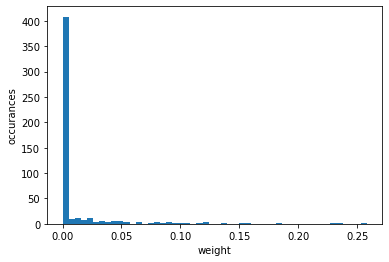

In [57]:
plt.hist(W.flatten(), bins=50)
plt.xlabel('weight')
plt.ylabel('occurances')
plt.show()

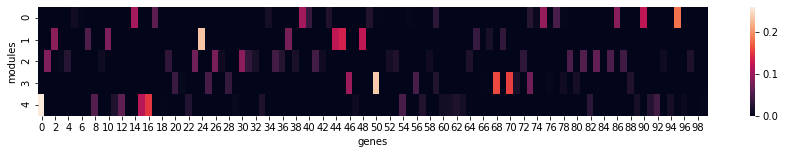

In [58]:
# Checking W
plt.figure(figsize=(15,2))
sns.heatmap(W.T) 
plt.ylabel('modules')
plt.xlabel('genes')
plt.show()

Unfortunately this does not really tell us anything other than our probability are between 0 and 1 and thus conform to what we set as parameters

We can see the weights but cannot really tell if the assignment worked. Let's normalize per gene, meaning we scale based on the sum of probabilities across genes and that should show us one battery per gene and for the moonlights, two batteries. Let's see.

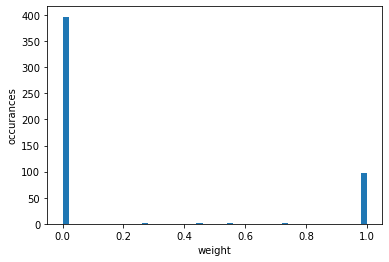

In [59]:
# Let's also check for normalized W
W_n = np.divide(W.T, np.sum(W, axis=1))
plt.hist(W_n.flatten(), bins=50)
plt.xlabel('weight')
plt.ylabel('occurances')
plt.show()

Great, we can see that we have values of 1 and 0 and a few inbetween for the moonlights.

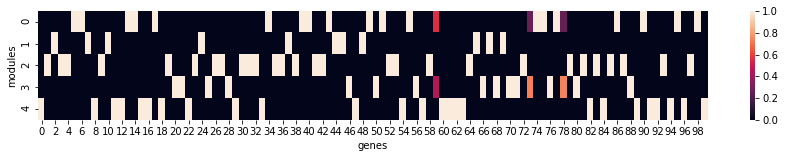

In [60]:
# Checking W_n
plt.figure(figsize=(15,2)) 
sns.heatmap(W_n)
plt.ylabel('modules')
plt.xlabel('genes')
plt.show()

Plotting a heatmap may not be the most intuitive but it allows us the see assignments and weights more clearly rather than just looking at the matrix. So we will use this representation to compare W's.

Great, we can clearly identify three moonlight genes and that the assignment worked. We also confirmed that the batteries have the right size and that W looks right. It seems to work!

## 2. implement nonnegative matrix factorization
In the synthesis step, we used W and H of our choosing to generate a data matrix V. In reality, we only observe (or measure) V, but we are actually interested in the matrix W - we want to know which genes belong to which batteries. To "extract" that information from V, we employ a method called non-negative matrix factorization. It tries to recreate W and H that best match the data V. Of course, this will not be perfect since V contains some noise that has nothing to do with H and W, but we can try to get as close as possible for the best guesses for W and H by using the LogLikelihood to determine parameter fit, i.e. how well do estimations of H and W fit V. We iteratively improve H and W such to converge to a point where changing W and H does not yield a large change in LLH. Since NMF is a local optimizer, we also want to be sure to run our calcualtions a few times and pick the one with the best Likelihood.

The formulas we use to arrive at an NMF algorithm were given in lecture and the only deviation from that notation made here is in terms of transposing matrixes as to multiply / dot product them.
We start with the update equations and calcualte them step by step:

- To get W', we divide V by lambda, which are the counts multiplied by our assumption of what WH looks like (Note here that since we are updating W and H, lambda changes too throughout the method). 
- Then we multiply each row of H with our row-like matrix of counts
- Finally, we build the dot product out of those two pieces and multiply it by W
- Then, we row normalize W and get W''

- To get H', we also divide V by lambda but dot product it with W (Note, this is the 'old' W and not the updated one)
- Then we multiply by H

All the neccessary dimensions and transpositions based on them are commented in the code

Essentially, all we are doing is calcualting a transformation that we apply onto W and H respectively to change their values to more reasonable values as we are getting closer to a matrix factorization that best fits the data V.

For the LogLikelihood, we use the equation 
$ log P(V∣W,H) = \sum_{\mu=1}^M \sum_{i=1}^N V_{i\mu} log(\lambda_{i\mu}) - \lambda_{i\mu} $
We can leave out the factorial as per section advice.


In [61]:
# Using the structure from section
def log_likelihood(V, C, W, H):
    """input
            V: observed counts matrix (NxM)
            C: total number of counts per experiment (Rx1)
            W: current weights matrix (NxR)
            H: current mixture coefficients matrix (RxM)
        output
            ll: total log likelihood of data given model
    """
    # Calculate expected counts V_exp from C, W, and H
    V_exp = C*(W@H) # lambda
    
    # Calculate loglikelihood using observed counts and expected counts
    # lambda = V_exp
    ll = np.sum(V*np.log(V_exp) - V_exp) # one sum is enough, sums over all elements since we do not specify axis
    
    return ll

In [62]:
def NMF(V, R, threshold = 1e-2):

    # dimW = N x R
    # dimH = R x M
    # V = N x M
    N, M = V.shape
    
    # init W and H randomly
    #W = np.zeros((N, R))
    W = np.random.dirichlet(np.ones(N), size=R).T
    H = np.random.dirichlet(np.ones(R), size=M).T
    
    # init C 
    C = np.sum(V, axis=0)
    
    # calc lambda
    V_exp = C*(W@H)
    
    # Keep track of Log Likelihood
    LLH = [np.inf, np.inf] # old and new
    
    # check llh until convergence
    converged = False
    while not converged:
        
        # Set previous LLH as old
        LLH[0] = LLH[1]
        
        # Update Step
        # I will be using np functions instead of shorthand notation to make it explicit what is happening
        # That way I understand better what is going on
        
        # CH
        # multiply every row (R) in H (1xM) with C (1xM)
        # result has size of H (RxM)
        CH = np.multiply(C,H)
        
        # V / lambda
        # They have the same size so elementwise
        # result is N x M
        VL = np.divide(V,V_exp)
        
        # How can we dot them?
        # they both have an M dimension
        # unfortunately both columns
        # Idea: transpose one to build dot product with same M
        # result is NxR
        
        VLCH = np.dot(VL,CH.T)
        
        # W is N x R so that can multiply elemtwise perfectly
        W1 = np.multiply(W,VLCH)
        
        # Next, we normalize and get W''
        W2 = np.divide(W1, np.sum(W1, axis=0))
        
        # Then we want to update H similarily
        # Here we again have the situation where W needs to be transposed
        # VL is NxM and W is NxR, we transpose and dot over N
        VLW = np.dot(W.T, VL)
        #print(VL.shape)
        #print(W.T.shape)
        #print(VLW.shape)
        H1 = np.multiply(H,VLW)
        
        # After getting W1, W2, H1, we assign them
        W = W2
        H = H1
        V_exp = C*(W@H)
        
        # Get LLH
        LLH[1] = log_likelihood(V, C, W, H)
        
        #print(LLH)
        
        # Check convergece criterion
        diff = abs(LLH[0] - LLH[1])
        #print(diff)
        if diff < threshold:
            converged = True
            
    return W, H, LLH[1]


In [63]:
def run_NMF(V, R, runs=10, txt=False):
    best = [0., 0., 0.] # W, H, LLH
    for run in range(runs):
        W, H, LLH = NMF(V, R, threshold = 1e-2)
        if txt:
            print('Iteration #', str(run+1), ' | LLH at ', str(LLH)) 
        if LLH > best[2]:
            W_norm = np.divide(W.T, np.sum(W, axis=1))
            best = [W, H, LLH, W_norm]
    return best

In [97]:
# Setting up data for random R
np.random.seed(42)
N, M, R = 100, 60, np.random.randint(3, 6, 1)[0]
print("Synthetic R: ", R)

# Simulate data
V, W, H, moonlights  = simulate_data(N, M, R)
print("Synthetic Moonlights: ", moonlights)

# running for best NMF, true R
best = run_NMF(V, R, runs=5, txt=True)

Synthetic R:  5
Synthetic Moonlights:  [78 73 59]
Iteration # 1  | LLH at  40034073.52310686
Iteration # 2  | LLH at  40034048.035661094
Iteration # 3  | LLH at  40034079.081053056
Iteration # 4  | LLH at  40034071.32318529
Iteration # 5  | LLH at  40034070.569720596


In [98]:
# running for different R
np.random.seed(42)
best_allR = []
for r in range(3,8):
    # run for that R
    # V is given, no other params to vary
    best = run_NMF(V, r, runs = 1, txt=False)
    print ('R = ', r, ' | LLH = ', best[2])
    best_allR.append(best)
    

R =  3  | LLH =  39276708.23071943
R =  4  | LLH =  39720268.51077072
R =  5  | LLH =  40034077.338995166
R =  6  | LLH =  40034125.49496319
R =  7  | LLH =  40034243.08854093


In [99]:
# Great, we can see that the LLH stagnates at R = 5
# which is the true R
# Let's see
bestW = best_allR[2][3]

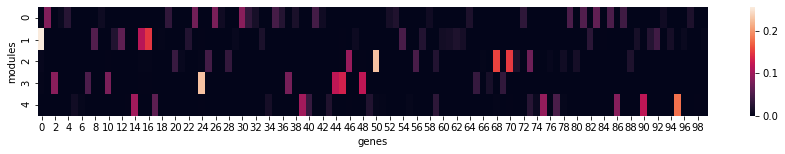

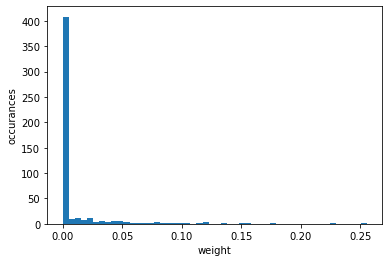

In [100]:
# plotting the best W, but non-normalized
plt.figure(figsize=(15,2))
sns.heatmap(best_allR[2][0].T)
plt.ylabel('modules')
plt.xlabel('genes')
plt.show()

plt.hist(best_allR[2][0].flatten(), bins=50)
plt.xlabel('weight')
plt.ylabel('occurances')
plt.show()

Here, we can see that while NMF comes up with positive weights for genes that belong to a battery, the rest of the probabilties are not exactly zero. That does not matter if we look at normalization later but is something to keep in mind if there should ever be a problem where the probabilities for the genes are way closer to zero than they are in this problem and dataset. We can also see that in the numbers by looking at best_allR[2][0].T but no need to print an entire matrix here. We get the idea.
Now, let's try with the row-normalized (across genes, i.e. normalize per gene) data matrix. 

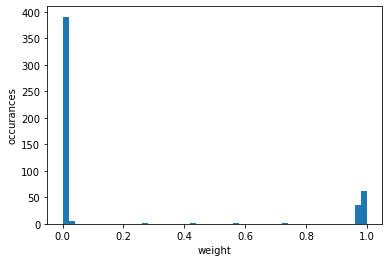

In [101]:
plt.hist(bestW.flatten(), bins=50)
plt.xlabel('weight')
plt.ylabel('occurances')
plt.show()

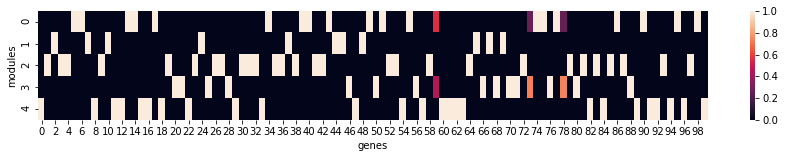

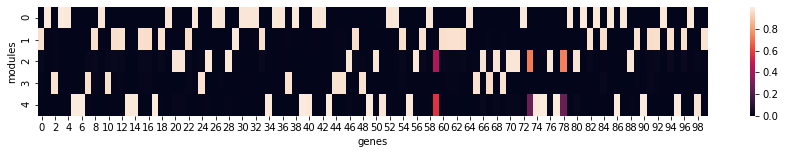

In [102]:
# plotting the true W
W_n = np.divide(W.T, np.sum(W, axis=1))
plt.figure(figsize=(15,2))
sns.heatmap(W_n) 
plt.ylabel('modules')
plt.xlabel('genes')
plt.show()

# plotting the best W
plt.figure(figsize=(15,2))
sns.heatmap(bestW)
plt.ylabel('modules')
plt.xlabel('genes')
plt.show()


Great, we can see that W seem to match well and that we can visually make out the moonlights. We can also see that the modules do not seem to match directly but those are arbitrary and if we order them by the genes that belong to them, the batteries containing the moonlights should match between the two W's.

Now, let's make this a bit more tangible. We can count the number of genes per modules and we can also find out which are the moonlight genes and assign them names. Here, the critical part is the threshold, that we can roughly set by looking at the histogram.

In [103]:
# Extract clusters
def get_batteries(W, threshold, return_ML=False, txt=True):
    
    moonlights = []
    rows, columns = W.shape
    modules = [[] for x in range(columns)]
    #print(modules)
    for i in range(rows):
        m_id = 0
        for j in range(columns):
            # print(W[i,j])
            if float(W[i,j]) > threshold:
                modules[j].append(i)
                m_id += 1
        if m_id > 1:
            # moonlight gene
            moonlights.append(i)
    if txt:
        print("Identified moonlights (idx): ", moonlights)
        print("Identified moonlights (names): ", genes[moonlights].tolist())

    # Order modules by length
    modules.sort(key=lambda s: len(s))
    
    overlap = set()
    for moonlight in moonlights:
        for idx, module in enumerate(modules):
            if moonlight in module:
                #print("Moonlight ", moonlight, "identified in module ", idx+1)
                overlap.add(idx+1)
                
    if txt:
        print("Overlapping Modules #", overlap, '\n')
    
        for idx, module in enumerate(modules):
            print("Module #", idx+1, " | Length: ", len(module), '\n')
        
    if return_ML:
        return len(moonlights)
        
 

In [111]:
# Threshold is kind of arbitrary, but looking at the ihstogram helped in identifying ~ 0.1
# getting clusters for true W (we know that already)
get_batteries(W_n.T, 0.2)

# getting clusters for NMF W 
get_batteries(bestW.T, 0.2)


Identified moonlights (idx):  [59, 73, 78]
Identified moonlights (names):  ['nectarine', 'pineapple', 'pumpkin']
Overlapping Modules # {2, 3} 

Module # 1  | Length:  11 

Module # 2  | Length:  17 

Module # 3  | Length:  22 

Module # 4  | Length:  25 

Module # 5  | Length:  28 

Identified moonlights (idx):  [59, 73, 78]
Identified moonlights (names):  ['nectarine', 'pineapple', 'pumpkin']
Overlapping Modules # {2, 3} 

Module # 1  | Length:  11 

Module # 2  | Length:  17 

Module # 3  | Length:  22 

Module # 4  | Length:  25 

Module # 5  | Length:  28 



## 3. analyze the Adler data

In [105]:
for r in range(3,8):
    W, H, LLH = NMF(np.array(V_a), r, threshold = 1e-2)
    print ('R = ', r, ' | LLH = ', LLH)

R =  3  | LLH =  40398456.07783157
R =  4  | LLH =  40796057.773460835
R =  5  | LLH =  40796146.98205508
R =  6  | LLH =  40796196.136119686
R =  7  | LLH =  40796281.90635849


Interesting, it seems like LLH stagnates at R = 4.
So we we identify that as the true number of modules and run the NMF with that value multiple times.

In [106]:
# running for best NMF
best = run_NMF(np.array(V_a), R=4, runs=8, txt=True)
W_a = best[3]

Iteration # 1  | LLH at  40795891.35025979
Iteration # 2  | LLH at  40795960.951767236
Iteration # 3  | LLH at  40795954.51008718
Iteration # 4  | LLH at  40796047.189449854
Iteration # 5  | LLH at  40796058.31814475
Iteration # 6  | LLH at  40796058.019186385
Iteration # 7  | LLH at  40796058.40882925
Iteration # 8  | LLH at  40796053.95952989


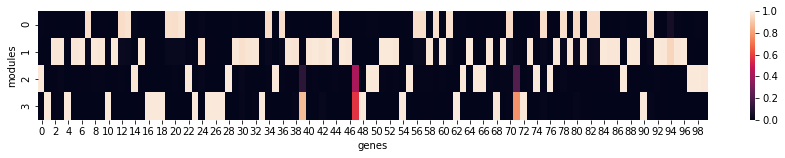

In [107]:
plt.figure(figsize=(15,2))
sns.heatmap(W_a)
plt.ylabel('modules')
plt.xlabel('genes')
plt.show()

It seems like there are three moonlight genes just based on visual confirmation. Let's also look at the histogram to try and get a threshold and then run the module assignment function.

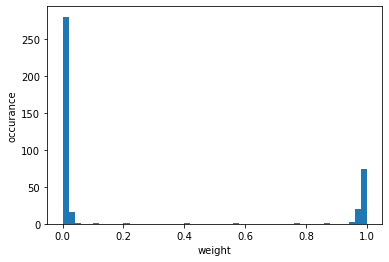

In [108]:
plt.hist(W_a.flatten(), bins=50)
plt.xlabel('weight')
plt.ylabel('occurance')
plt.show()

In [115]:
# Lenient threshold
get_batteries(W_a.T, 0.1)

# Strict threshold
get_batteries(W_a.T, 0.2)


Identified moonlights (idx):  [39, 47, 71]
Identified moonlights (names):  ['grape', 'kohlrabi', 'pepper']
Overlapping Modules # {2, 3} 

Module # 1  | Length:  20 

Module # 2  | Length:  20 

Module # 3  | Length:  20 

Module # 4  | Length:  43 

Identified moonlights (idx):  [47, 71]
Identified moonlights (names):  ['kohlrabi', 'pepper']
Overlapping Modules # {1, 3} 

Module # 1  | Length:  19 

Module # 2  | Length:  20 

Module # 3  | Length:  20 

Module # 4  | Length:  43 



Also note here that modules 1, 2, and 3 aren't neccessarily the numbers for the original modules of Adler's data. Since they all have the same length, we would only match modules across data generation if we compare comprising genes. Here, we can say that the moonlighters were in modules with length 20 each. Another module w/o moonlighters also had length 20 and the remaining module had length 43. 

Since the threshold is a major component in (mis)identifying moonlights. Finally, we want to figure out how senstive it is w.r.t this data.

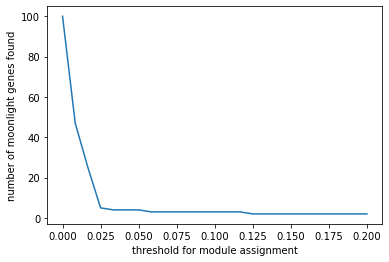

In [110]:
# We get different results based on the treshold and this seems to be one of the drawbacks 
# since we might miss moonlighting genes if they might have even more disperesed probabilities

moonlight_n = []
thresholds = np.linspace(0., 0.2, num=25)
for t in thresholds:
    moonlight_n.append(get_batteries(W_a.T, t, return_ML=True, txt=False))
plt.plot(thresholds, moonlight_n)
plt.xlabel('threshold for module assignment')
plt.ylabel('number of moonlight genes found')
plt.show()

This analysis kind of reminds me of the Bonferroni or q value comparison. If we set a really strict threshold such that we may even miss some true moonlights, we make sure to identify those that are ver likely moonlights (above 0.2 for example) but miss out on one's that are moonlights too but not as clearly. And in fact, we can see that with Adler and thresolding at 0.2. Then we only identify two moonlights. The more lenient we are with the threhold, the more moonlights we indentify, but that also means that we may very well have some false postives. So, depending on how many ressources one has and what to do with the identified moonlights after the analysis, one might to be either conservative and restric tmoonlights, or one might be open to inccuring some faulty moonlights.

For the Adler data, I would settle on the lenient threshold and say we have three moonlights ['grape', 'kohlrabi', 'pepper'] with batteries of 20,20,20,43 lengths. This is also guided by the visual representation of W.

Finally, we can say that NMF worked pretty well on our synthetic data, as well as on Adler's data. We saw how useful it is the generate synthetic data to test the algorithm an sniff out possible complications (such as the cutoff expression probability). 
However, out data was pretty "simple" the way it was generated. We only had genes be shared across two batteries - in reality, that is usually much more complicated and that can lead to cases where the identification with NMF isn't so clear since the probabilities are all closer together (here, it was pretty clear to see which genes were only on in one battery). This might be a potential drawback and would suggest that further study or refinment is neccessary in pinpointing moonlights. Finally, I am feeling really good about having implemented this algorithm from scratch and with the help of the paper - something that not only taught me how to do the maths and biology but also something that gave me some trust in my ability to read and recreate actual academic work!